# Merging EB terms-  NLS -  Encyclopaedia Britannica


### Loading the necessary libraries

In [2]:
import yaml
import matplotlib.pyplot as plt
import numpy as np
import collections
import matplotlib as mpl

In [3]:
import pandas as pd
from yaml import safe_load
from pandas.io.json import json_normalize

### Functions

In [4]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = safe_load(f)
    return query_results


In [5]:
def write_query_results(filename, results):
    with open('./results_NLS/'+filename, 'w') as f:
        documents = yaml.dump(results, f)

In [6]:
def create_dataframe(query_results):
  
    
    for edition in query_results:
        for page in query_results[edition]:
            #print(page[1].keys())
            column_list=list(page[1].keys())
            break
        break
        
    data=[]
    for edition in query_results:
        for page in query_results[edition]:
            try:
                data.append(page[1])
               
            except:
                pass
    df = pd.DataFrame(data, columns = column_list)
    #removing the columns that I dont need 
    df= df.drop(['last_term_in_page', 'model', 'num_articles', 'num_page_words', 'num_text_unit' , 'text_unit', 'type_archive'], axis=1)
    #renaming the page num
    df= df.rename(columns={"text_unit_id": "page_num"})
    #removing 'Page' from the string
    df["page_num"] = df["page_num"].str.replace("Page", "")
    df_tmp= df["edition"].str.split("Volume", expand=True)[1].str.split(",", expand=True)
    df["volume"]= df_tmp[0]
    df["letters"] = df_tmp[1]
    df['volume'] = df["volume"].str.replace(" ", "")
    

    list_editions={"1":["first", "First"], "2":["second", "Second"],\
               "3":["third", "Third"],\
               "4":["fourth", "Fourth"], \
               "5":["fifth","Fifth"], "6":["sixth","Sixth"],\
               "7":["seventh", "Seventh"], "8":["eighth", "Eighth"]} 
    
    for ed in list_editions:
        for ed_versions in list_editions[ed]:
            mask = df["edition"].str.contains(ed_versions)
            df.loc[mask, 'edition_num'] = ed                            
            
    
    return df

In [7]:
def create_dataframe_from_file(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = safe_load(f)
    
    df = create_dataframe(query_results)
    return df

In [8]:
def prune_json(json_dict):
    """
    Method that given a JSON object, removes all its empty fields.
    This method simplifies the resultant JSON.
    :param json_dict input JSON file to prune
    :return JSON file removing empty values
    """
    final_dict = {}
    if not (isinstance(json_dict, dict)):
        # Ensure the element provided is a dict
        return json_dict
    else:
        for a, b in json_dict.items():
            if b or isinstance(b, bool):
                if isinstance(b, dict):
                    aux_dict = prune_json(b)
                    if aux_dict:  # Remove empty dicts
                        final_dict[a] = aux_dict
                elif isinstance(b, list):
                    aux_list = list(filter(None, [prune_json(i) for i in b]))
                    if len(aux_list) > 0:  # Remove empty lists
                        final_dict[a] = aux_list
                else:
                    final_dict[a] = b
    return final_dict

In [9]:
def delete_entries(query_results_updated, eliminate_pages):
    new_results={}
    for edition in query_results_updated:
        new_results[edition]=[]
        for page_idx in range(0, len(query_results_updated[edition])):
            if page_idx not in eliminate_pages[edition]:
                new_results[edition].append(query_results_updated[edition][page_idx])
    return new_results

In [10]:
def merge_terms(query_results):
    eliminate_pages={}
    for edition in query_results:
        eliminate_pages[edition]=[]
        page_number_dict={}
        for page_idx in range(0, len(query_results[edition])):
            
            current_page=query_results[edition][page_idx][0]
            if current_page not in page_number_dict:
                page_number_dict[current_page]=page_idx
        
            element = query_results[edition][page_idx][1]
            if "previous_page" in element['term']:
                current_definition= element["definition"]
                previous_page_idx= page_idx -1
                previous_page_number = current_page -1
                num_article_words=element["num_article_words"]
                related_terms=element["related_terms"]
                
                
                prev_elements = query_results[edition][previous_page_idx][1]
                if prev_elements["last_term_in_page"]:
                   
                    prev_elements["definition"]+=current_definition
                    prev_elements["num_article_words"]+=num_article_words
                    prev_elements["related_terms"]+= related_terms
                    prev_number = int(prev_elements['text_unit_id'].split("Page")[1])
                    
                    for prev_articles_idx in range(page_number_dict[prev_number], page_idx):
                       
                        if query_results[edition][prev_articles_idx][0] == prev_number:
                           
                            query_results[edition][prev_articles_idx][1]["num_page_words"]+=num_article_words
                    
                  
                    for update_element_idx in range(page_number_dict[current_page], page_idx+1):
                        if query_results[edition][update_element_idx][0] == current_page:
                            query_results[edition][update_element_idx][1]["num_page_words"]-=num_article_words
                            query_results[edition][update_element_idx][1]["num_articles"]-=1
                    
                
                eliminate_pages[edition].append(page_idx)
              
   
    new_results= delete_entries(query_results, eliminate_pages)
    
    return new_results

## Reading, Merging articles,  and Writing the results in a new file

In [11]:
query_results=read_query_results('results_eb_first_2volumes')

In [13]:
query_results_updated =merge_terms(query_results)

In [14]:
write_query_results("results_eb_first_2volumes_updated", query_results_updated)

## Creating a dataframe from the updated results

Here we have dropped some columns that we dont longer need. 

- archive_filename:     File Path of the XML file from which the article belongs
- definition:           Definition of the article
- edition:              Edition (it also has the volume name)
- header:               Header of the page's article                                  
- num_article_words:    Number of words per article
- place:                Place where the volume was edited                                     
- related_terms:        Related articles   
- source_text_file:     XML file        
- term:                 Article name                            
- term_id_in_page:      Number of article in the page     
- page_num:                 Page Number
- title:               Title of the Volume
- type_page:            Type of Page [Full Page| Topic| Mix | Articles]                                       
- year:                 Year of the Volume
- volume:               volume (e.g. 1)
- letters:              leters of the volume (A-B)
- edition_num:           1,2,3,4,5,6,7,8


In [12]:
df=create_dataframe_from_file("results_eb_first_2volumes_updated")

In [67]:
#df=create_dataframe(query_results_updated)

In [69]:
df.tail()

,archive_filename,definition,edition,header,num_article_words,place,related_terms,source_text_file,term,term_id_in_page,page_num,title,type_page,year,volume,letters,edition_num
9616,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"in botany, agenusof the dodecandria monogynia ...","First edition, 1771, Volume 2, C-L",LYMLYT,56,Edinburgh,[],alto/144925806.34.xml,LYTHRUM,15,1015,"Encyclopaedia Britannica; or, A dictionary of ...",Articles,1771,2,C-L,1
9617,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,A T A I! End of the article CATASTROPHE. For S...,"First edition, 1771, Volume 2, C-L",EKATAI,906,Edinburgh,[],alto/144925818.34.xml,EKATAI,0,1016,"Encyclopaedia Britannica; or, A dictionary of ...",FullPage,1771,2,C-L,1
9618,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"c°l * I * 31* Tor"" of the tocher and the ’wife...","First edition, 1771, Volume 2, C-L",ERRATA,23,Edinburgh,[],alto/144925830.34.xml,P,1,1017,"Encyclopaedia Britannica; or, A dictionary of ...",Articles,1771,2,C-L,1
9619,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"col. 2.1. 8, 9. For “ ’ward' ho/ding' was in d...","First edition, 1771, Volume 2, C-L",ERRATA,260,Edinburgh,[],alto/144925830.34.xml,P_def,2,1017,"Encyclopaedia Britannica; or, A dictionary of ...",Articles,1771,2,C-L,1
9620,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"Read lines 3d, 4th, and jth, of the (irftpa^ r...","First edition, 1771, Volume 2, C-L",ERRATA,43,Edinburgh,[],alto/144925830.34.xml,LOGIC,3,1017,"Encyclopaedia Britannica; or, A dictionary of ...",Articles,1771,2,C-L,1


In [70]:
df.iloc[0]

archive_filename     /Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...
definition           n*s-f 7^' v L i A j J ^ /^^W / ; H:;^’ J }r-r£...
edition                             First edition, 1771, Volume 1, A-B
header                                                   iiiubnsfvnsfv
num_article_words                                                   58
place                                                        Edinburgh
related_terms                                                       []
source_text_file                                 alto/188082735.34.xml
term                                                     iiiubnsfvnsfv
term_id_in_page                                                      0
page_num                                                             2
title                Encyclopaedia Britannica; or, A dictionary of ...
type_page                                                     FullPage
year                                                              1771
volume

In [20]:
df.to_json(r'./results_NLS/postprocess_dataframe_eb_first_2volumes', orient="index") 

## Related Terms

In [72]:
df_related=df[df['related_terms'].apply(lambda x: len(x)) > 0]

In [73]:
df_related=df_related.explode('related_terms')

In [74]:
df_related

,archive_filename,definition,edition,header,num_article_words,place,related_terms,source_text_file,term,term_id_in_page,page_num,title,type_page,year,volume,letters,edition_num
19,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"in ichthyology, a barbarous name of the zeus v...","First edition, 1771, Volume 1, A-B",EncyclopaediaBritannica,19,Edinburgh,ZEUS,alto/188082904.34.xml,ABACATUAIA,12,15,"Encyclopaedia Britannica; or, A dictionary of ...",Articles,1771,1,A-B,1
20,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"AY, a barbarous name of a species of the pfitt...","First edition, 1771, Volume 1, A-B",EncyclopaediaBritannica,14,Edinburgh,PSITTACUS,alto/188082904.34.xml,ABAC,13,15,"Encyclopaedia Britannica; or, A dictionary of ...",Articles,1771,1,A-B,1
22,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,See ABACUS.,"First edition, 1771, Volume 1, A-B",EncyclopaediaBritannica,2,Edinburgh,ABACUS,alto/188082904.34.xml,ABACISCUS,15,15,"Encyclopaedia Britannica; or, A dictionary of ...",Articles,1771,1,A-B,1
36,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"in botany, a fynonime of the calycanthus prtec...","First edition, 1771, Volume 1, A-B",ABAABB,22,Edinburgh,CALYCANTHUS,alto/188082917.34.xml,ABAI,8,16,"Encyclopaedia Britannica; or, A dictionary of ...",Articles,1771,1,A-B,1
37,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,See ABASED.,"First edition, 1771, Volume 1, A-B",ABAABB,2,Edinburgh,ABASED,alto/188082917.34.xml,ABAISSE,9,16,"Encyclopaedia Britannica; or, A dictionary of ...",Articles,1771,1,A-B,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9600,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,between tbe head and the neck to which the oth...,"First edition, 1771, Volume 2, C-L",IITTfV,1019,Edinburgh,LUXEMBURG,alto/144925794.34.xml,IITTfV,0,1014,"Encyclopaedia Britannica; or, A dictionary of ...",Topic,1771,2,C-L,1
9600,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,between tbe head and the neck to which the oth...,"First edition, 1771, Volume 2, C-L",IITTfV,1019,Edinburgh,LYBIA,alto/144925794.34.xml,IITTfV,0,1014,"Encyclopaedia Britannica; or, A dictionary of ...",Topic,1771,2,C-L,1
9600,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,between tbe head and the neck to which the oth...,"First edition, 1771, Volume 2, C-L",IITTfV,1019,Edinburgh,LYCHNIS,alto/144925794.34.xml,IITTfV,0,1014,"Encyclopaedia Britannica; or, A dictionary of ...",Topic,1771,2,C-L,1
9600,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,between tbe head and the neck to which the oth...,"First edition, 1771, Volume 2, C-L",IITTfV,1019,Edinburgh,LYCODONTES,alto/144925794.34.xml,IITTfV,0,1014,"Encyclopaedia Britannica; or, A dictionary of ...",Topic,1771,2,C-L,1


In [75]:
import networkx as nx
graph_df = nx.from_pandas_edgelist(df_related, source='term', target='related_terms', edge_attr=True)

In [76]:
graph_df

/anaconda3/envs/mypython3/lib/python3.7/site-packages/networkx-2.2-py3.7.egg/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/envs/mypython3/lib/python3.7/site-packages/networkx-2.2-py3.7.egg/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


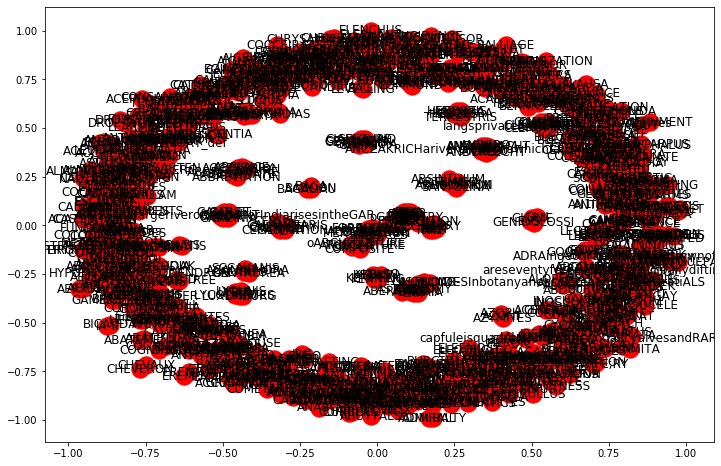

In [77]:
import matplotlib.pyplot as plt
#matplotlib inline

plt.figure(figsize=(12,8))
nx.draw_networkx(graph_df, with_labels=True)

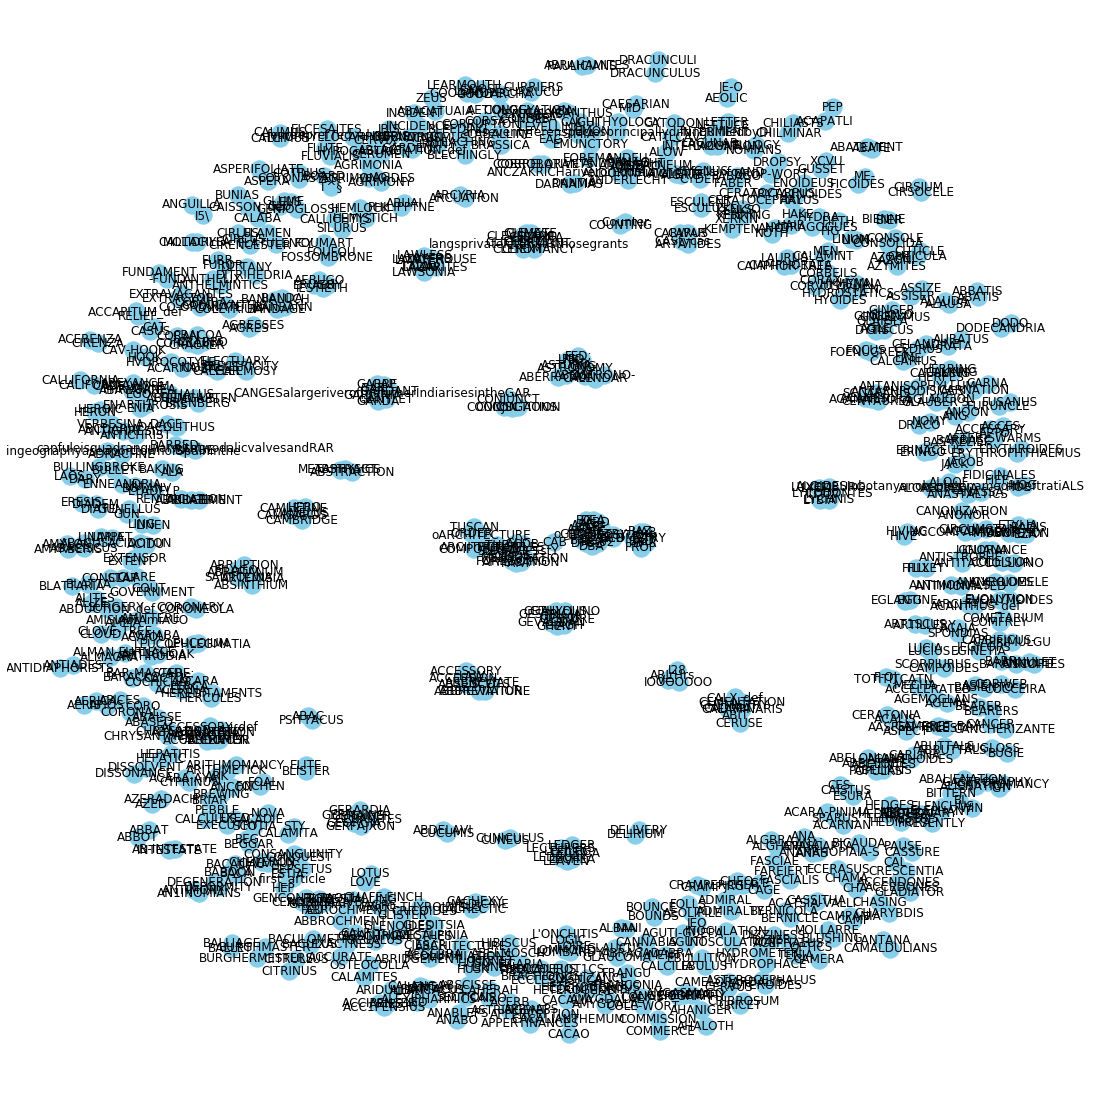

In [78]:
plt.figure(figsize=(15,15))

pos = nx.spring_layout(graph_df)
nx.draw(graph_df, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()